<h2> Creating a WCL Plot

<h5> <p>This code shows how to read WCL data and output an image.
<p>The code es ported from 'read_image_wcl_nc.pro' and 'plot_wcl_power_dep.pro' authored by Min Deng into a python script.  
<p>Notes:
<ul>
<li>The 'xarray' package is the only "non-standard" python package used here, but saves time in reading ND-array variables from a NetCDF.</li>
<li>The main processing is done using pandas.</li>
</ul>

<h3> Import needed packages

In [1]:
import xarray
from xarray import ufuncs
import pandas as pd
import numpy as np
import bottleneck as bn

import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

<h3> Set variables used in the script

In [2]:
filename = '/Users/guy/data/pecan/aircraft.UWyo_King_Air.20150608040001.WCL_Backscatter_Depol.nc'

# Constants applied to get Depolarization factor, different for every case
# Best guess here
depconstA = 3.67589
depconstB = 4.5

<h3> Open the NetCDF data file

In [3]:
data=xarray.open_dataset(filename, decode_times=True)
#data.dims
#data.coords
#data.data_vars
data

<xarray.Dataset>
Dimensions:       (profile: 600, range: 5375, vector3: 3)
Coordinates:
  * profile       (profile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * range         (range) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * vector3       (vector3) int64 0 1 2
Data variables:
    Time          (profile) datetime64[ns] 2015-06-08T04:00:01 ...
    time          (profile) datetime64[ns] 2015-06-08T04:00:01 ...
    Range         (range) float32 -289.5 -288.0 -286.5 -285.0 -283.5 -282.0 ...
    CopolPower    (range, profile) float32 0.00332058 0.00332058 0.00332058 ...
    CrossPower    (range, profile) float32 -0.00100142 -0.000957402 ...
    CopolOverlap  (range) float32 9.96921e+36 9.96921e+36 9.96921e+36 ...
    CrossOverlap  (range) float32 9.96921e+36 9.96921e+36 9.96921e+36 ...
    CopolBG       (profile) float32 0.000331346 0.000331081 0.000327999 ...
    CrossBG       (profile) float32 0.000294481 0.000301624 0.000307497 ...
    CopolBGSTD    (profile) flo

### Now pull out power and range data

In [4]:
r = xarray.DataArray((data.data_vars['Range']/1000.)).to_dataframe().squeeze()

p1 = pd.DataFrame(data=data.data_vars['CopolPower'].values.T, index=data.data_vars['Time'],
                                   columns=data.data_vars['Range'])
p2 = pd.DataFrame(data=data.data_vars['CrossPower'].values.T, index=data.data_vars['Time'],
                                   columns=data.data_vars['Range'])

# Now let's make 2D arrays for plotting
Yalt2D, Alt2D = np.meshgrid(data.data_vars['Range'].values, data.data_vars['ALT'].values)
Time2D = np.empty_like(Yalt2D, dtype=data.data_vars['Time'].dtype)
# This next step could use some speeding up, but the datatype doesn't allow np.meshgrid call
for i in range(Yalt2D.shape[1]):
    Time2D[:,i] = data.data_vars['Time'].values
data.data_vars['Time'].shape, Yalt2D.shape
#junk, Time2Db= np.meshgrid(data.data_vars['Range'].values, np.array(data.data_vars['Time'].values, dtype=np.datetime64))


# Create an array with the common expression of lidar power
# Note: Do not use this going forward with data manipulation, as we are making this non-linear
# Only for display purposes
dbPow = 10. * ufuncs.log10(data.data_vars['CopolPower'].values)

Yalt2D = Yalt2D + Alt2D

### Let's take a look at the raw data

/Users/guy/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


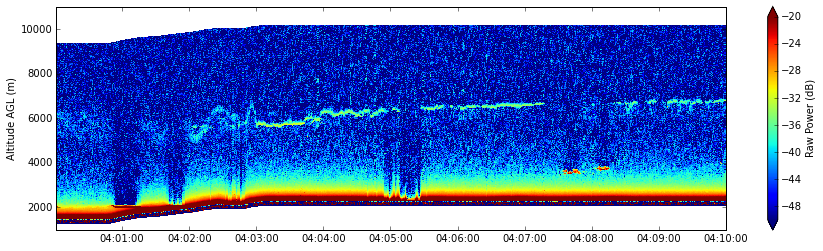

In [5]:
fig, ax = plt.subplots(figsize=(15, 4))
plt.pcolormesh(Time2D, Yalt2D, dbPow.T, vmin=-50, vmax=-20)
ax.set_ylabel("Altitude AGL (m)")
cb1 = plt.colorbar(extend='both')
cb1.set_label('Raw Power (dB)')

### Now we can process the data
<h4> Use a window smoothing function from bottleneck (bn).</h4>

In [6]:
# Raw power data as a function of the square of the range
# Apply a moving mean smoothing function with widths of 11 time samples and 33 gates
#p1r2 = pd.rolling_mean(p1.mul(r.values**2, axis='columns'), 11)
#p2r2 = pd.rolling_mean(p2.mul(r.values**2, axis='columns'), 11)
p1r2 = p1.mul(r.values**2, axis='columns')
p2r2 = p2.mul(r.values**2, axis='columns')

p1r2_sm = bn.move_mean(p1r2, window=33, axis=1)
p2r2_sm = bn.move_mean(p2r2, window=33, axis=1)
p1r2_sm = bn.move_mean(p1r2_sm, window=11, axis=0)
p2r2_sm = bn.move_mean(p2r2_sm, window=11, axis=0)

# Calculate the depolarization ratio
dep   = p2r2_sm/p1r2_sm/depconstA/depconstB

# Create a decibel representation of processed power
dbp1r2 = 10. * ufuncs.log10(p1r2.values)
dbp1r2_sm = 10. * ufuncs.log10(p1r2_sm)
#p1.shape, p1r2.shape, dep.shape, p1r2_sm.shape

### Let's look at the depolarization ratio

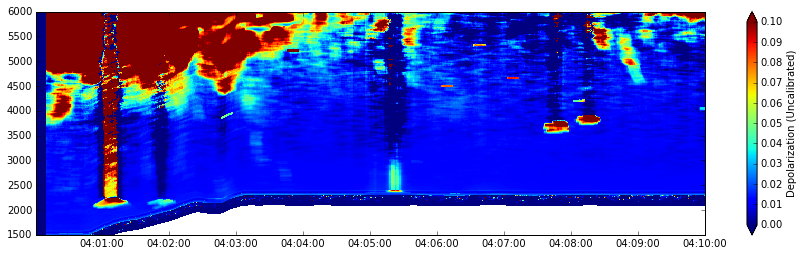

In [7]:
fig, ax1 = plt.subplots(figsize=(15, 4))
plt.pcolormesh(Time2D, Yalt2D, dep, vmin=0., vmax=0.1)
plt.ylim((1500,6000))
ax.set_ylabel("Altitude AGL (m)")
ax.set_xlabel("UTC Time")
cb1 = plt.colorbar(extend='both')
cb1.set_label('Depolarization (Uncalibrated)')

### Processed power at the lower levels, no smoothing and then smoothing applied

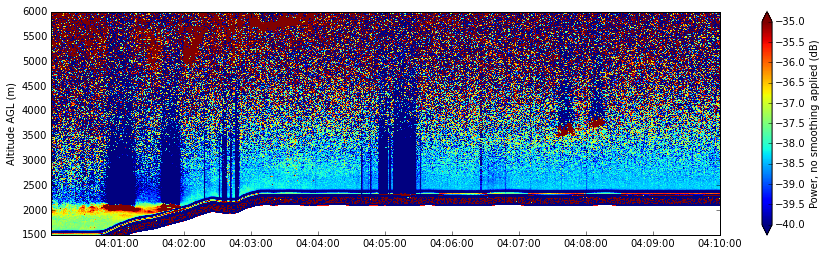

In [8]:
fig, ax = plt.subplots(figsize=(15, 4))
#plt.pcolormesh(Time2D, Yalt2D, dbp1r2, vmin=-50, vmax=-20)
plt.pcolormesh(Time2D, Yalt2D, dbp1r2, vmin=-40, vmax=-35)
plt.ylim((1500,6000))
ax.set_ylabel("Altitude AGL (m)")
cb1 = plt.colorbar(extend='both')
cb1.set_label('Power, no smoothing applied (dB)')

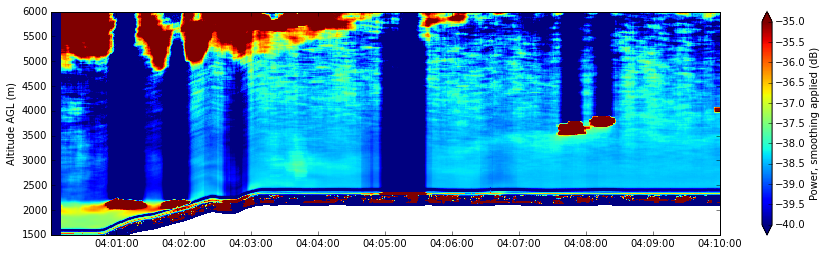

In [9]:
fig, ax = plt.subplots(figsize=(15, 4))
plt.pcolormesh(Time2D, Yalt2D, dbp1r2_sm, vmin=-40, vmax=-35)
plt.ylim((1500,6000))
ax.set_ylabel("Altitude AGL (m)")
cb1 = plt.colorbar(extend='both')
cb1.set_label('Power, smoothing applied (dB)')